In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from typing import List
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
import os

# Where to save the figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=120):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
df = pd.read_csv("../input/train.csv")
df.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [4]:
df['video_duration'] = df.duration.apply(lambda x: re.findall(pattern='\d+\w+', string=x)[0])

In [5]:
def get_time(time_ext: str, 
             duration: List[str], 
             time_name: str, 
             df: pd.DataFrame
             )->pd.DataFrame:
    for idx, x in enumerate(duration):
        m = re.search(pattern=f"\d+{time_ext}", string=x)
        if m is not None:
            df.loc[idx, time_name] = m.group()
        else:
            df.loc[idx, time_name] = f'0{time_ext}'
    df[time_name] = df[time_name].str.replace(time_ext, '')
    df[time_name] = df[time_name].astype(int)
    return df

In [6]:
df = get_time(time_ext='H', duration=df.video_duration.values, time_name='Hour', df=df)
df = get_time(time_ext='M', duration=df.video_duration.values, time_name='Minute', df=df)
df = get_time(time_ext='S', duration=df.video_duration.values, time_name='Second', df=df)


In [7]:
# 1 hour = 60 min
# 1 min = 60 sec
# 1 sec = 1/60 min

df["Second_to_min"] = df["Second"] / 60
df["Hour_to_min"] = df["Hour"] *60
df["Total_Time"] = df["Second_to_min"] + df["Hour_to_min"] + df["Minute"]
df.drop(["Hour", "Minute", "Second", "Second_to_min", "Hour_to_min"], axis=1, inplace= True)

df.head(5)
    

,vidid,adview,views,likes,dislikes,comment,published,duration,category,video_duration,Total_Time
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F,7M37S,7.616667
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D,9M30S,9.500000
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C,2M16S,2.266667
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H,4M22S,4.366667
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D,31S,0.516667


In [8]:
label_enc = LabelEncoder()
df['category_enc'] = label_enc.fit_transform(df.category)

In [9]:
import seaborn as sns

In [10]:
# df[df.comment=="F"].empty

# df.drop(df[df.views=='F'].index, axis=0, inplace= True)
# df.drop(df[df.likes=='F'].index, axis=0, inplace= True)
# df.drop(df[df.comment=='F'].index, axis=0, inplace=True)

In [11]:
# col_to_numeric = df.columns[df.dtypes=="object"]
col_to_numeric = ['adview', 'views', 'likes', 'dislikes', 'comment', 'Total_Time', 'category_enc']
print(col_to_numeric)

['adview', 'views', 'likes', 'dislikes', 'comment', 'Total_Time', 'category_enc']


In [12]:
for ele in tqdm(range(len(col_to_numeric))):
    if df[df[col_to_numeric[ele]]=='F'].empty:
        df= df
    else:
        df = df.drop(df[df[col_to_numeric[ele]]=='F'].index, axis=0)

df[col_to_numeric] = df[col_to_numeric].astype(int)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 158.72it/s]


Saving figure Views vs All Features


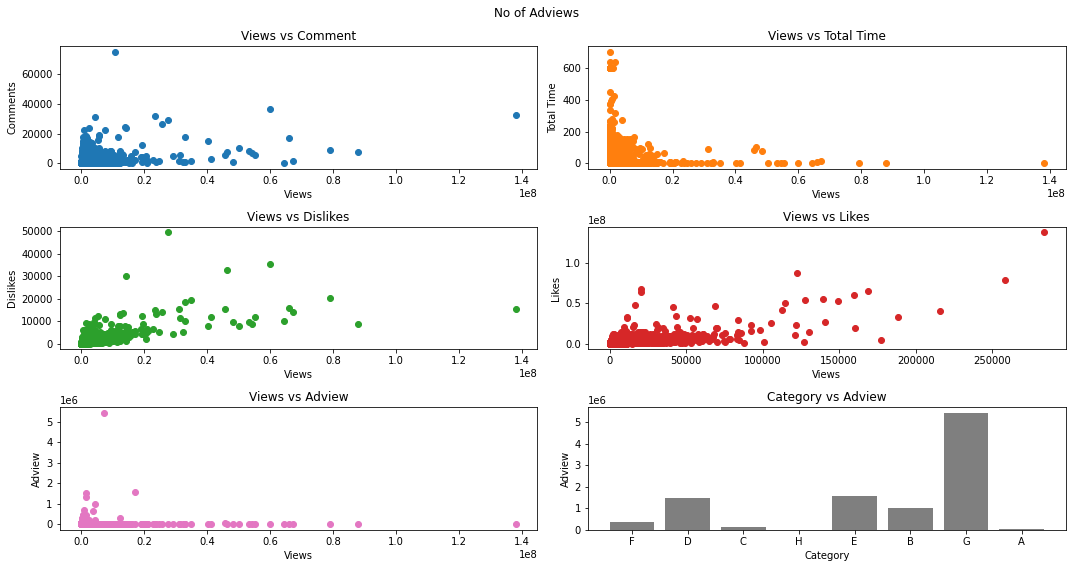

In [13]:
fig, axes= plt.subplots(nrows=3, ncols=2, figsize=(15, 8))
fig.suptitle("No of Adviews")

axes[0, 0].scatter(df.views.values,df.comment.values)
axes[0, 0].set_title("Views vs Comment")
axes[0, 0].set_xlabel("Views")
axes[0, 0].set_ylabel("Comments")

axes[0, 1].scatter(df.views.values,df.Total_Time.values, color="tab:orange")
axes[0, 1].set_title("Views vs Total Time")
axes[0, 1].set_xlabel("Views")
axes[0, 1].set_ylabel("Total Time")

axes[1, 0].scatter(df.views.values,df.dislikes.values, color="tab:green")
axes[1, 0].set_title("Views vs Dislikes")
axes[1, 0].set_xlabel("Views")
axes[1, 0].set_ylabel("Dislikes")



axes[1, 1].scatter(df.likes.values,df.views.values, marker='o', color="tab:red")
axes[1, 1].set_title("Views vs Likes")
axes[1, 1].set_xlabel("Views")
axes[1, 1].set_ylabel("Likes")

axes[2, 0].scatter(df.views.values,df.adview.values, color="tab:pink")
axes[2, 0].set_title("Views vs Adview")
axes[2, 0].set_xlabel("Views")
axes[2, 0].set_ylabel("Adview")

axes[2, 1].bar(df.category.values,df.adview.values, color="tab:grey")
axes[2, 1].set_title("Category vs Adview")
axes[2, 1].set_xlabel("Category")
axes[2, 1].set_ylabel("Adview")

plt.tight_layout()
save_fig("Views vs All Features")
plt.show()


In [15]:
cols_to_drop = ['vidid', 'published', 'duration','category', 'video_duration']
df.drop(cols_to_drop, axis=1, inplace=True)
df.head()

,adview,views,likes,dislikes,comment,Total_Time,category_enc
0,40,1031602,8523,363,1095,7,5
1,2,1707,56,2,6,9,3
2,1,2023,25,0,2,2,2
3,6,620860,777,161,153,4,7
4,1,666,1,0,0,0,3


Saving figure Correlation_plot.png


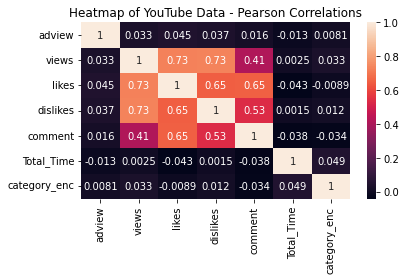

In [16]:
correlations = df.corr()
# annot=True displays the correlation values
sns.heatmap(correlations, annot=True).set(title='Heatmap of YouTube Data - Pearson Correlations');
save_fig("Correlation_plot.png")

### Normalizaton of Dataset

In [ ]:
# from sklearn.preprocessing import StandardScaler

# # Normalizing the data 

# scaler = StandardScaler()

# names = df.columns
# d = scaler.fit_transform(df)
# scaled_df = pd.DataFrame(d, columns=names)
# scaled_df.head()

### MODEL BUILDING

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
SEED = 42

X = df.drop("adview", axis=1)
y = df["adview"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [20]:
print(X_train)
print(y_train)

         views  likes  dislikes  comment  Total_Time  category_enc
12545    26171     12         2        5          48             6
7923     34417    143         2       44          10             3
3012     26086     19         0        9           2             5
1888    305445   3662        45      555           4             6
5279    120739    766        16      227           4             6
...        ...    ...       ...      ...         ...           ...
5316     31648    140        24       14           3             6
13747     3435     27         0        0           1             3
5522    204817     86        35       11           3             3
883    1361366   1384       757      185           4             6
7445     39758    122         6        3           5             3

[11709 rows x 6 columns]
12545        1
7923         3
3012     18782
1888         2
5279         1
         ...  
5316     21127
13747      809
5522         1
883          2
7445         1
Name:

In [21]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

regressor.fit(X_train, y_train)

print(regressor.intercept_)

print(regressor.coef_)

y_pred = regressor.predict(X_test)

df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
print(df_preds)



1477.6545989916608
[ 2.25887888e-05  2.54675617e-01 -5.51899174e-01 -4.11062717e-01
 -1.18176656e+01  6.15435524e+00]
       Actual    Predicted
4912        5  1755.853549
4921        2  1502.790045
3813        5  1337.434804
9092        1  1732.416845
8486        1  1338.011258
...       ...          ...
3788        1  1517.683052
12152       1  1258.774361
9152        3  1603.773098
769         2  1565.101968
7039        5  3123.423119

[2928 rows x 2 columns]


In [30]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 4950.31
Mean squared error: 10883666018.54
Root mean squared error: 104324.81


In [23]:
regr = RandomForestRegressor(max_depth=2, random_state=SEED)
regr.fit(X_train, y_train)

# Train Score
train_score = regr.score(X_train, y_train)

# Test Score
test_score = regr.score(X_test, y_test)

# Write scores to a file
with open('../input/metrics.txt', 'w') as outfile:
    outfile.write("Training variance explained: %2.1f%%\n" % train_score)
    outfile.write("Test varinace explained: %2.1f%%\n" % test_score)

    

### PLOT FEATURE IMPORTANCE

<function matplotlib.pyplot.close(fig=None)>

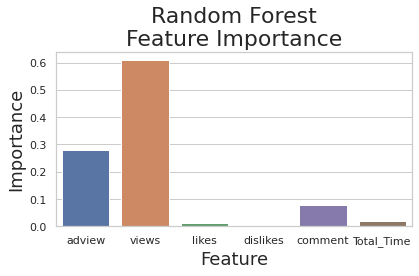

In [24]:
importance = regr.feature_importances_
labels = df.columns
feature_df = pd.DataFrame(list(zip(labels, importance)), columns=['Features', 'Importances'])


# Image formatting

axis_fs = 18
title_fs = 22
sns.set(style="whitegrid")

ax = sns.barplot(x = "Features", y="Importances", data=feature_df)
ax.set_xlabel("Feature", fontsize=axis_fs)
ax.set_ylabel("Importance", fontsize = axis_fs)

ax.set_title("Random Forest\nFeature Importance", fontsize= title_fs)

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, "imagesFeature_Importance.png"), dpi=120)
plt.close


### PLOT RESIDUALS

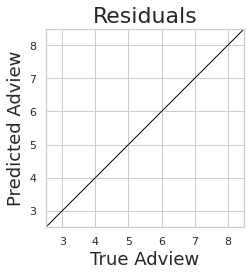

In [29]:
y_pred = regr.predict(X_test) + np.random.normal(0,0.25,len(y_test))
y_jitter = y_test + np.random.normal(0,0.25,len(y_test))
res_df = pd.DataFrame(list(zip(y_jitter,y_pred)), columns = ["true","pred"])

ax = sns.scatterplot(x="true", y="pred",data=res_df)
ax.set_aspect('equal')
ax.set_xlabel('True Adview',fontsize = axis_fs) 
ax.set_ylabel('Predicted Adview', fontsize = axis_fs)#ylabel
ax.set_title('Residuals', fontsize = title_fs)

# Make it pretty- square aspect ratio
ax.plot([1, 10], [1, 10], 'black', linewidth=1)
plt.ylim((2.5,8.5))
plt.xlim((2.5,8.5))

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, "residuals.png"),dpi=120)